## 2.0 Exploratory Data Analysis ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

In [6]:
# career = pd.read_csv('ir_career.csv')
career = pd.read_csv('data/all_pos_ir_career.csv')

,player,1,2,3,4,5,6,7,8,9
0,A'Shawn Robinson,Healthy,Healthy,Knee,Healthy,Healthy,Healthy,NaN,NaN,NaN
1,A.J. Brown,Healthy,Healthy,Chest,NaN,NaN,NaN,NaN,NaN,NaN
2,A.J. Cann,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Knee,NaN,NaN
3,A.J. Derby,Undisclosed,Healthy,Shoulder,Foot,Healthy,Healthy,Healthy,NaN,NaN
4,A.J. Epenesa,Healthy,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2282,Zaven Collins,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2283,Zaviar Gooden,NaN,Healthy,Hamstring,Healthy,Healthy,Healthy,Healthy,Healthy,NaN
2284,Zay Jones,Healthy,Healthy,Healthy,Healthy,Healthy,NaN,NaN,NaN,NaN
2285,Zech McPhearson,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So far,  we've been able to create a representation of each player's career as a vector of Injuries (or Status of 'Healthy') where each item in the vector corresponds to the season number of their career.  Season Numbers provide us a convenient way to measure the veteranness of a player. Our assumption is that as a player accummulates more seasons, they more than likely will have a higher probability of incurring an IR injury. The higher the probability for injury, the less likely we'll be to draft them in the early rounds and wait for the risk/reward to be more palatable.

Before we delve into player details, let's see if we can glean insights by position.

### 2.1 Back to the Basics

In [5]:
# Let's get some quick summary statistics on how many players we have for each position:

career.position.value_counts()

AttributeError: 'DataFrame' object has no attribute 'position'

<font color=red>Red Flag: Given data is only able to go back to 2013, our numbers are small (low statistical power) and I suspect we'll have many permutations of injuries, further reducing that power. Given this limitation, i feel it's best to model across the entire player dataset and not by position. </font>  Regardless, we'll still want to look at the statistics by position to see if there are any interesting details, including frequency of injuries by position type.  

First, let's get a quick breakdown of the number of player's whose careers span the number of seasons (1-9) we're working with. My assumption would be that we'd see higher numbers of player counts in seasons 1-4, and then a marked decline as we move through the later seasons...

In [150]:
df_long = career.melt(id_vars=['player','position'],
                  value_vars=[str(x) for x in range(1,10)])
df_long['variable'] = df_long['variable'].astype('int64')

df_long.to_csv('data/df_long.csv', sep='|', index=False)
# Remove the Nan Values (artifact of melting each player's career according to the number of seasons available)
df_nonan = df_long[df_long['value'].isna()==False]

# Get the max (highest) season that the player played
maxes = df_nonan.groupby(['player','position'])[['variable']].max().reset_index()


maxes.groupby('position')[['variable']].agg(['mean','median','std'])

variable                 
              mean median       std
position                           
QB        4.368932    4.0  2.191742
RB        4.434783    4.0  2.210818
TE        4.519084    4.0  2.233835
WR        4.228070    4.0  2.217230

In [5]:
# For each number of seasons value (1-9) get the counts of how many players were in that category
career_len_counts = maxes.groupby(['position','variable'])[['player']].count().reset_index()


# pivot (rotate) the dataframe so that the seasons are listed as columns and the count of players whose career
# spanned the corresponding number of seasons is the value in the cell.  Index by position.
career_len_counts = career_len_counts.pivot(index='position', columns='variable', values='player')

career_len_counts

variable,1,2,3,4,5,6,7,8,9
position,,,,,,,,,
QB,10.0,16.0,13.0,17.0,14.0,13.0,7.0,13.0,NaN
RB,22.0,26.0,32.0,26.0,32.0,25.0,19.0,24.0,1.0
TE,13.0,14.0,22.0,20.0,18.0,11.0,17.0,14.0,2.0
WR,36.0,42.0,39.0,44.0,38.0,31.0,27.0,25.0,3.0


In [6]:
for idx, position in enumerate(career_len_counts.index):
    values = career_len_counts.iloc[idx].values
    print(values)

[10. 16. 13. 17. 14. 13.  7. 13. nan]
[22. 26. 32. 26. 32. 25. 19. 24.  1.]
[13. 14. 22. 20. 18. 11. 17. 14.  2.]
[36. 42. 39. 44. 38. 31. 27. 25.  3.]


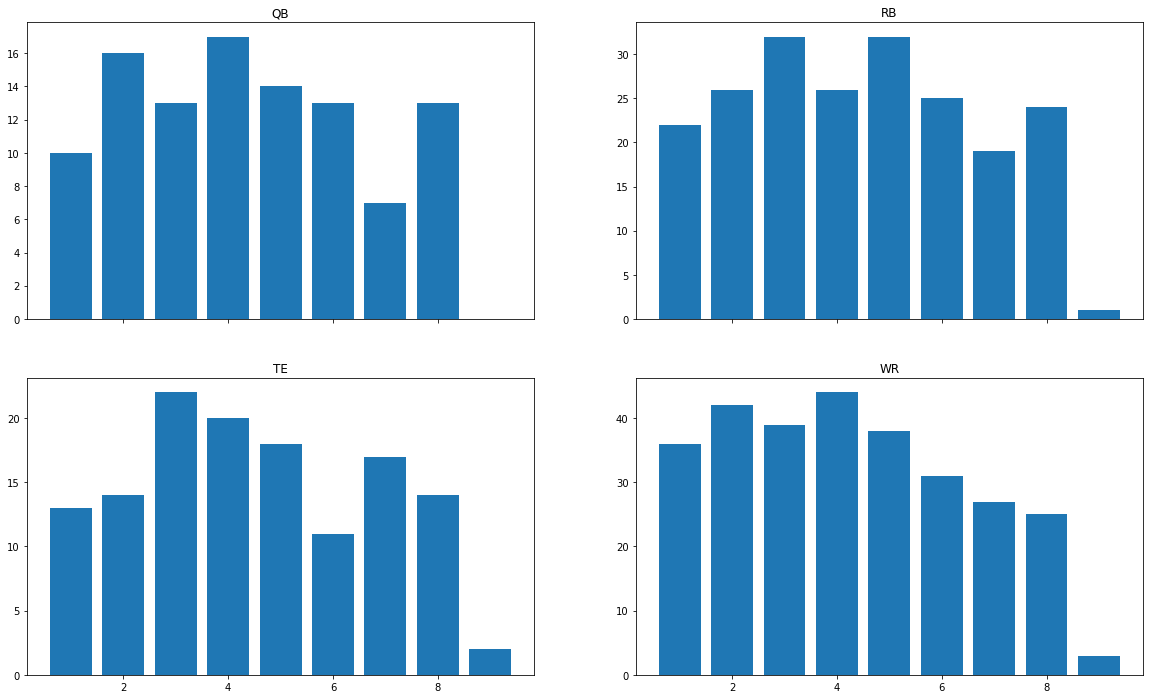

In [7]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(20,12))

axes = axes.flatten()
for idx, position in enumerate(career_len_counts.index):
    values = career_len_counts.iloc[idx]
    x = career_len_counts.columns
    axes[idx].bar(x,values)
    axes[idx].set_title(position.upper())
plt.show()

Not as substantial of a drop-off as I expected, but this might be the issue with the sample size. The basic statistics above show that (based on our sample) each position has an expected career length between 4 and 5 seasons. Looking at the bar charts:
   - For QBs and WRs, it appears we have the most players with careers of 4 seasons, 
   - RBs have a tie between 3 and 5 season careers.  
   - Tight Ends have the highest frequency in the 3 seasons bucket. However, there is a slight "bump" in the number of players that played 7 seasons which moved the mean over a bit for this position.
   
For TEs and WRs, you can see a consistent declining trend after the 3rd and 4th seasons. An interesting follow-up question (out-of-scope here: "How does this compare to un-drafted players?"

Let's take a look at how the various IR-related injuries are distributed across all of the player seasons.  We'll create a heatmap where the injury types are specified along the y-axis, the season numbers are listed along the x-axis and we'll mark the number of players as text & color intensity. 

In [99]:
import altair as alt


htmp = df_long.groupby(['variable','value']).count().reset_index()
htmp = htmp[htmp['value'] != 'Healthy']
char = alt.Chart(htmp).mark_rect().encode(
 x=alt.X('variable:O', title='Season'),
    y = alt.Y('value:N', title='Injury'),
    color = alt.Color('player:Q')
)

text = char.mark_text(
    align='left',
    baseline='middle',
    fill = 'black'
).encode(
    text='player:Q'
)



fullchart = char + text

fullchart.properties(width=400,
                     height=800,
                     title="IR Injuries By Season and Type (n=726)")


alt.LayerChart(...)

Analsysis: We can see simply by studying the color that Knees, Ankle, Hamstring and Foot injures maintain high frequencies across the seasons of a players career.  Note: I chose to keep the text in the map here vs solely using color as the range of numbers is rather small.

Let's look at this from another angle - what do the probabilities look like of a player staying off the Injured Reserve for each of the season numbers, keeping in mind that our sample is still relatively small due to the website constraints and at risk of violating the law of large numbers.

Once again, I'll refer back to the long-form of the careers data to calculate each season's probability.  All players who didn't have a stint on the Injured Reserve will have a "Healthy" designation in the "value" column. Any other value indicates injury.  Any NaN value (non-existent season for a player) or 9th season (too few observations) will be filtered out.


In [111]:
import seaborn as sns

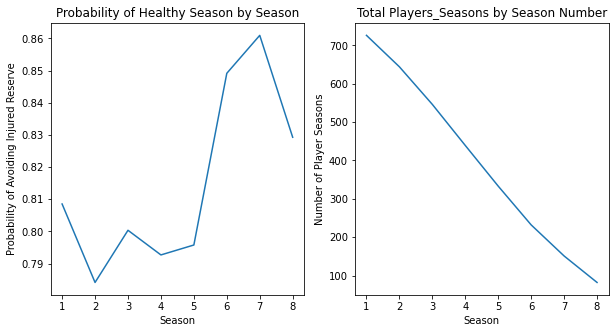

In [124]:

def getProb(srs):
    return len([i for i in srs if i =='Healthy'])  / len(srs)


# filter out seasons the player didn't play & season 9 since very few observations
p_s = df_long[(df_long.value.isna()==False) &
             (df_long.variable < 9)]

# groupby and call our custom aggregate function and count
data = p_s.groupby('variable')[['value']].agg([getProb,'count'])
data.columns = ['prob','player_seasons']



fig, axes = plt.subplots(1,2, sharex=True, figsize=(10,5))
axes.flatten() # this makes it easier to reference the specific axes
# create the two plots 
sns.lineplot(x=data.index, y=data.prob, ax=axes[0])
axes[0].set_title("Probability of Healthy Season by Player Season Number")
sns.lineplot(x=data.index, y=data.player_seasons, ax=axes[1])
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Probability of Avoiding Injured Reserve")
axes[1].set_title("Total Players_Seasons by Season Number");
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Number of Player Seasons");

Based off our sample, there's a slightly higher probability of having a healthy season later in a player's careers (if their career allows for it).  A longer career could be the result of the following:
1) The player has an above average skillset for their position and has value to the team(s) they play for
2) Either in conjunction with #1 or independent of it, as a player gets older, they may receive fewer reps and thus have fewer opportunities to get injured compared to when they were younger.

As expected, we see a decreasing player pool for each successive season  

### 2.2 Injury Frequency

Though we've done quite a bit of work in building a career sequence of IR stints for each player, we should also consider each sequence as a sort of itemset of injuries. Itemsets won't address when or in what order an injury occurs but provides insight on frequency and co-occurence with other injuries. Recall the representation of the career dataframe:

In [127]:
career

,player,position,1,2,3,4,5,6,7,8,9
0,A.J. Brown,WR,Healthy,Healthy,Chest,NaN,NaN,NaN,NaN,NaN,NaN
1,A.J. Derby,TE,Undisclosed,Healthy,Shoulder,Foot,Healthy,NaN,NaN,NaN,NaN
2,A.J. McCarron,QB,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Knee,NaN
3,AJ Dillon,RB,Healthy,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aaron Burbridge,WR,Healthy,Hamstring,Hamstring,Healthy,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
721,Zach Gentry,TE,Healthy,Knee,Healthy,NaN,NaN,NaN,NaN,NaN,NaN
722,Zach Mettenberger,QB,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,NaN
723,Zach Wilson,QB,Healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,Zack Moss,RB,Ankle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can use sklearn's Multilabelbinarizer to represent the careers as sets (immutable collections of, in this case,  unique injuries).  This approach loses fidelity if we want to see the number of recurring injuries (e.g. repeated knee injuries) but it's valuable for the analysis mentioned above.

In [133]:
from sklearn.preprocessing import MultiLabelBinarizer

In [134]:
cols = [x for x in career.columns[2:]]
mlb = MultiLabelBinarizer()

# Reduce the dataset only to just the season columns, fill in the nan values with blanks,
# transform the data and create a new dataframe where each injury is a column of binary values

ir_itms = pd.DataFrame(data=mlb.fit_transform(career[cols].fillna('').values), 
                                                    columns = mlb.classes_)
ir_itms.shape

(726, 40)

In [135]:
# Let's import some libraries that will make our analysis easier...
from mlxtend.frequent_patterns import apriori, association_rules

One of the questions we want to understand is frequency of injury.  We get some basic understanding of this question by looking at the relative support of each individual and combination of injuries. For an individual item, relative support is simply the ratio of players who incurred a specific injury

In [136]:
def getFrequentItemsets(df, threshold=.01, k=2):
    
    ''' Takes a binarized dataset and provides an analysis of support based on a specificed threshold 
    Parameters:
    -----------
        df - a binarized dataframe
        threshold - float (default = .01) The minimum threshold for support. itemset threshold 
        underneath this value will be filtered out
        k - 'int' (default=2) the size of the itemset to filter on
        
    Returns:
    --------
        a dataframe containing a itemsets and their relative support from highest to lowest
    
    '''
    
    itmst = apriori(df, min_support=threshold, use_colnames=True)
    itmst.sort_values("support", ascending=False, inplace=True)
    itmst = itmst[itmst['itemsets'].map(len)==k]
    return itmst
    

In [138]:
# Let's first look at the support for individual items...we'll use length of 1
ir_freq_sets = getFrequentItemsets(ir_itms, threshold=.01, k=1)
ir_freq_sets

,support,itemsets
0,0.991736,()
10,0.961433,(Healthy)
11,0.192837,(Knee)
2,0.103306,(Ankle)
9,0.071625,(Hamstring)
15,0.060606,(Undisclosed)
7,0.059229,(Foot)
14,0.048209,(Shoulder)
5,0.031680,(Concussion)
3,0.023416,(Back)


Ignoring the blanks (they represent the seasons AFTER a player's career ended and are meaningless to us) we see 96% of drafted players had at least one "Healthy" season.  Remember, this analysis only factors those cases where a player landed on IR but omits non-IR related injuries (cases where a player might've sat out 1 or a few games).

IR Injuries related to Knees appear to be the most common by quite a large margin.  Nearly 20% of our sample had at least one knee injury.  If you're a fantasy pro, this makes sense and a player incurring a knee injury mid-season is disasterous for both the player and your season esp. if it's an ACL tear.  

The next 3 are all related to lower body injuries: ankle (10.3%) and hamstring (7%) injuries.  

We can't derive a lot of information in 'Undisclosed info' as that could be any body part/condition. However, in keeping with the theme of the top 3, we see foot injuries affect nearly 6% of our sampled players.

We see the remainder of injuries above our threshold being a mix of upper body and lower body afflictions.

Now, let's dig a little deeper and see which injuries can appear with some frequency in football players' careers:

In [139]:
# Since we're dealing with 2-frequent itemsets, I'm going to lower the threshold
ir_freq_sets = getFrequentItemsets(ir_itms, threshold=.001, k=2)

# I want to focus specifically on 2-itemsets and want to filter out Healthy and blanks for obvious reasons
ir_freq_sets[(ir_freq_sets['itemsets'].apply(lambda x: False if "Healthy" in x else True)) &
            (ir_freq_sets['itemsets'].apply(lambda x: False if "" in x else True))][:25]

,support,itemsets
105,0.023416,"(Ankle, Knee)"
168,0.016529,"(Knee, Hamstring)"
102,0.011019,"(Ankle, Hamstring)"
100,0.009642,"(Ankle, Foot)"
206,0.008264,"(Knee, Shoulder)"
157,0.008264,"(Knee, Foot)"
139,0.005510,"(Knee, Concussion)"
144,0.005510,"(Undisclosed, Concussion)"
225,0.005510,"(Undisclosed, Shoulder)"
163,0.005510,"(Knee, Groin)"


Interestingly, we see that Knee and Ankle injuries are the most frequently occurring pair of ir-injuries in a player's career, regardless of career length.  This makes sense since an injury to one, could alter the mechanics of a player's movements and lead to the second injury.  Since we're dealing with itemsets, the order is not relevant here, just the pairings.  We'll see later on which injury is more likely to occur first.

we see some sort of pairing of knee and other related injuries in 6 of the top 10 pairings. Further validating the notion that knees are the champions of the Gridiron Gurney.

Despite the league's focus on Concussions (which is appropriate concerning their severity), it's still the lower appendages that bear the highest volume. 

Just to be sure our numbers are correct - we see that 2% of players have both Knee and Ankle IR stints sometime during their career - we can do some quick math (726 players multipled by .0234... is roughly 17 cases). We can validate this against the career dataframe by running some quick filters:


In [91]:
career[(career.isin(['Knee']).any(axis=1)) &
      (career.isin(['Ankle']).any(axis=1))]

,player,position,1,2,3,4,5,6,7,8,9
98,Charles Johnson,WR,Healthy,Healthy,Healthy,Healthy,Knee,Healthy,Ankle,NaN,NaN
109,Chris Gragg,TE,Healthy,Healthy,Healthy,Knee,Ankle,Healthy,Healthy,Healthy,NaN
166,Darrell Henderson,RB,Ankle,Ankle,Knee,NaN,NaN,NaN,NaN,NaN,NaN
247,Equanimeous St. Brown,WR,Healthy,Ankle,Knee,Healthy,NaN,NaN,NaN,NaN,NaN
248,Eric Ebron,TE,Healthy,Healthy,Healthy,Healthy,Healthy,Ankle,Healthy,Knee,NaN
298,Jaelen Strong,WR,Healthy,Ankle,Knee,Healthy,Healthy,NaN,NaN,NaN,NaN
318,James O'Shaughnessy,TE,Foot,Healthy,Healthy,Healthy,Knee,Healthy,Ankle,NaN,NaN
344,Jeremy Hill,RB,Healthy,Healthy,Healthy,Ankle,Knee,Healthy,Healthy,NaN,NaN
352,Jimmy Garoppolo,QB,Healthy,Healthy,Healthy,Healthy,Knee,Healthy,Ankle,Healthy,NaN
432,Kenjon Barner,RB,Healthy,Ankle,Healthy,Hamstring,Healthy,Knee,Healthy,Groin,NaN
